**Content**

First let's import everything we need to run the rest of the notebook.

In [41]:
# Prevent multi-threading upon initialising mpi4py
import os,mpi4py
os.environ["OMP_NUM_THREADS"] = "1";
mpi4py.rc.thread_level = 'single';

import numpy as np
import scipy.stats as ss
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt

**Problem Equations**

The Boussinesq equations are given by
\begin{align}
\begin{split}
     \frac{D \boldsymbol{U} }{Dt}&= -\nabla P + Re^{-1} \Delta \boldsymbol{U} + B \boldsymbol{z}, \quad \nabla \cdot \boldsymbol{U} = 0, \\
    \frac{D B }{Dt}         &= Pe^{-1}\nabla^2 B, \quad \text{on} \quad  \Omega: [0,L/H] \times [0,1],
\end{split}
\end{align}
subject to the no-slip velocity and buoyancy boundary conditions. We assume periodicity in the horizontal and simulate Rayleigh-B\'enard.

In [42]:
# Solver
def Solve(T=50,Nx=256,Nz=64):

    Ra=2e06
    Pr=1

    # Bases
    coords = d3.CartesianCoordinates('x', 'z')
    dist   = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, 4), dealias=3/2)
    zbasis = d3.ChebyshevT( coords['z'], size=Nz, bounds=(0, 1), dealias=3/2)

    # Fields
    p = dist.Field(name='p', bases=(xbasis,zbasis))
    b = dist.Field(name='b', bases=(xbasis,zbasis))
    u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
    tau_p  = dist.Field(name='tau_p')
    tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
    tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
    tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
    tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

    # Substitutions
    kappa= (Ra * Pr)**(-1/2) # 1/Pe
    nu   = (Ra / Pr)**(-1/2) # 1/Re
    x, z = dist.local_grids(xbasis, zbasis)
    ex,ez= coords.unit_vector_fields(dist)
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
    grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

    # Problem
    problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
    problem.add_equation("trace(grad_u) + tau_p = 0")
    problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
    problem.add_equation("u(z=0) = 0")
    problem.add_equation("u(z=1) = 0") # no-slip
    problem.add_equation("integ(p) = 0") # Pressure gauge
    problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = -u@grad(b)")
    problem.add_equation("b(z=1) = 0")
    problem.add_equation("b(z=0) = 1") 

    # Solver
    solver = problem.build_solver(d3.RK222)
    solver.stop_sim_time = T

    # Initial condition
    b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
    b['g'] *= z * (1 - z) # Damp noise at walls
    b['g'] += 1 - z # Add linear background
    
    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.1)
    snapshots.add_task(b,    name='b',scales=3/2)
    # snapshots.add_task(grad_b       , name='grad_b',scales=3/2)
    # snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity',scales=1)
    # snapshots.add_task(u@ex, name='u',scales=3/2)
    # snapshots.add_task(u@ez, name='w',scales=3/2)
    # snapshots.add_task(d3.grad(u@ez), name='grad_w',scales=3/2)
    # snapshots.add_task(d3.grad(p)   , name='grad_p',scales=3/2)

    # CFL
    CFL = d3.CFL(solver, initial_dt=0.1, cadence=10, safety=0.5, threshold=0.05, max_change=1.5, min_change=0.5, max_dt=0.1)
    CFL.add_velocity(u)

    # Main loop
    logger.info('Starting main loop')
    while solver.proceed:

        # Compute the 
        dt = CFL.compute_timestep()  # dt = t_n+1 - t_n
        solver.step(dt)

        if (solver.iteration-1) % 1000 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, dt))

    return None

We use the solver to generate a dataset starting from $B(\bm{x},t=0) = 1-z$.

In [43]:
Solve(T=100,Nx=256,Nz=64)

2025-01-28 13:32:58,549 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 8s, Rate: 1.6e+01/s
2025-01-28 13:32:58,911 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 3.1e+01/s
2025-01-28 13:32:59,296 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 3.2e+01/s
2025-01-28 13:32:59,679 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 3.3e+01/s
2025-01-28 13:33:00,059 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 2s, Remaining: 2s, Rate: 3.3e+01/s
2025-01-28 13:33:00,441 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 3.3e+01/s
2025-01-28 13:33:00,832 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 2s, Remaining: 2s, Rate: 3.3e+01/s
2025-01-28 13:33:01,224 subsystems 0/1 INFO :: Building subprobl

Then we calculate the PDF

In [64]:
# Calculate the PDF
from scipy.interpolate import interp1d

Nz = 512

def interp(y, x, x_new):
  """Interpolate the Chebyshev points onto a uniform grid."""
  y_new = interp1d(x, y, axis=1, fill_value="extrapolate")
  return y_new(x_new)

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')
times = file['tasks/b'].dims[0][0][:]
pad = np.argwhere(times > 30)[0,0]

# Interpolate the data (t,x,z) from a Chebyshev grid onto a uniform grid
x_data = file['tasks/b'].dims[1][0][:]
z_cheb = file['tasks/b'].dims[2][0][:]
times  = file['tasks/b'].dims[0][0][:]
B_cheb = file['tasks/b' ][:,:,:]

z_data  = np.linspace(0,1,Nz)
s       = (len(times[:]),len(x_data),len(z_data))
B_data  = np.zeros(s)
for i,t in enumerate(times[:]):
  B_data[i,:,:] = interp(B_cheb[i,:,:], z_cheb, z_data)

Then we calculate the stratification profile

In [70]:
# Calculate the stratification profile
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Data (t,x,z)
x_vec = file['tasks/b'].dims[1][0][:]
z_vec = file['tasks/b'].dims[2][0][:]
t_vec = file['tasks/b'].dims[0][0][:]
B_vec = file['tasks/b' ][:,:,:]

from scipy.integrate import trapezoid as trapz

Then we plot the figures, starting with the conductive state first

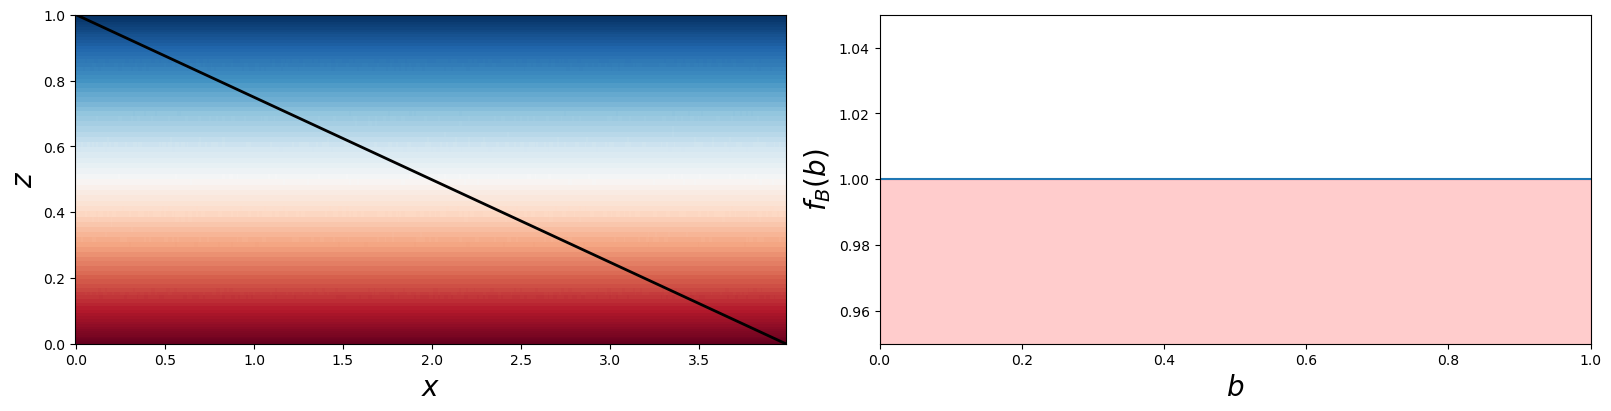

In [71]:
#from matplotlib import rc
#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', size=20.0)

fB, b_edges = np.histogram(B_data[0,:,:].flatten(), bins=16, density=True)
EzB = trapz(y=B_vec[0,:,:], x=x_vec, axis=0)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,4), layout='constrained')

# Space plot
X,Z = np.meshgrid(x_vec, z_vec)
ax[0].pcolormesh(X, Z, B_vec[0,:,:].T,cmap='RdBu_r',norm='linear')
ax[0].plot(EzB,z_cheb,'k-',linewidth=2)
ax[0].set_xlabel(r'$x$',fontsize=20)
ax[0].set_ylabel(r'$z$',fontsize=20)

# PDF
b = np.linspace(0,1,128)
fB = np.ones(128)
ax[1].plot(b, fB)
ax[1].fill_between(x=b,y1=fB,color= "r",alpha= 0.2)
ax[1].set_xlabel(r'$b$',fontsize=20)
ax[1].set_ylabel(r'$f_B(b)$',fontsize=20)
ax[1].set_xlim([0,1])
ax[1].set_ylim([0.95,1.05])

fig.savefig("Conduction.png", dpi=100)
plt.show()

And then the convective state

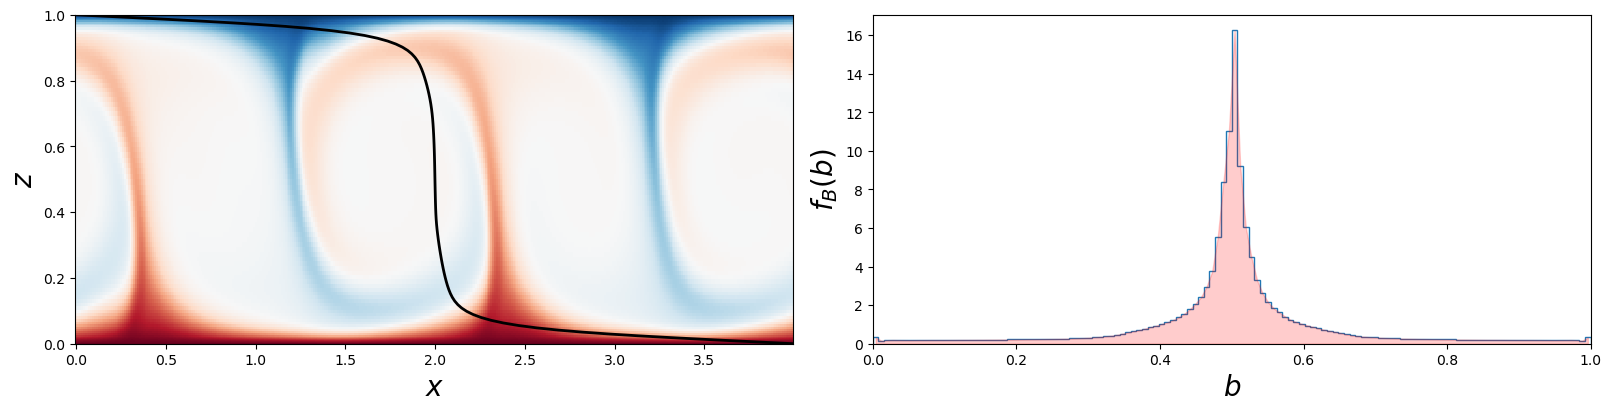

In [74]:
#from matplotlib import rc
#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', size=20.0)

fB, b_edges = np.histogram(B_data[pad:,:,:].flatten(), bins=128, density=True)
EzB = np.mean(trapz(y=B_vec[pad:,:,:], x=x_vec, axis=1),axis=0 ) 

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,4), layout='constrained')

# Space plot
X,Z = np.meshgrid(x_vec, z_vec)
ax[0].pcolormesh(X, Z, B_vec[-1,:,:].T,cmap='RdBu_r',norm='linear')
ax[0].plot(EzB,z_cheb,'k-',linewidth=2)
ax[0].set_xlabel(r'$x$',fontsize=20)
ax[0].set_ylabel(r'$z$',fontsize=20)

# PDF
ax[1].stairs(fB, b_edges)
b = (b_edges[1:] + b_edges[:-1])/2
ax[1].fill_between(x=b,y1=fB,color= "r",alpha= 0.2)
ax[1].set_xlabel(r'$b$',fontsize=20)
ax[1].set_ylabel(r'$f_B(b)$',fontsize=20)
ax[1].set_xlim([0,1])

fig.savefig("Convection.png", dpi=100)
plt.show()